##### Copyright 2019 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Build a digit classifier app with TensorFlow Lite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/examples/digit_classifier/ml/mnist_tflite.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/lite/examples/digit_classifier/ml/mnist_tflite.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

This notebook shows an end-to-end example of training a TensorFlow model using Keras and Python, then export it to TensorFlow Lite format to use in mobile apps. Here we will train a handwritten digit classifier using MNIST dataset.


## Setup

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math

print(tf.__version__)

# Helper function to display digit images
def show_sample(images, labels, sample_count=25):
  # Create a square with can fit {sample_count} images
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images), len(labels))
  
  plt.figure(figsize=(2*grid_count, 2*grid_count))
  for i in range(sample_count):
    plt.subplot(grid_count, grid_count, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.gray)
    plt.xlabel(labels[i])
  plt.show()

2.6.0


## Download and explore the MNIST dataset
The MNIST database contains 60,000 training images and 10,000 testing images of handwritten digits. We will use the dataset to demonstrate how to train a image classification model and convert it to TensorFlow Lite format.

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit.
![MNIST sample](https://storage.googleapis.com/khanhlvg-public.appspot.com/digit-classifier/mnist.png)

In [2]:
# Download MNIST dataset.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# If you can't download the MNIST dataset from Keras, please try again with an alternative method below
# path = keras.utils.get_file('mnist.npz',
#                             origin='https://s3.amazonaws.com/img-datasets/mnist.npz',
#                             file_hash='8a61469f7ea1b51cbae51d4f78837e45')
# with np.load(path, allow_pickle=True) as f:
#   train_images, train_labels = f['x_train'], f['y_train']
#   test_images, test_labels = f['x_test'], f['y_test']

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

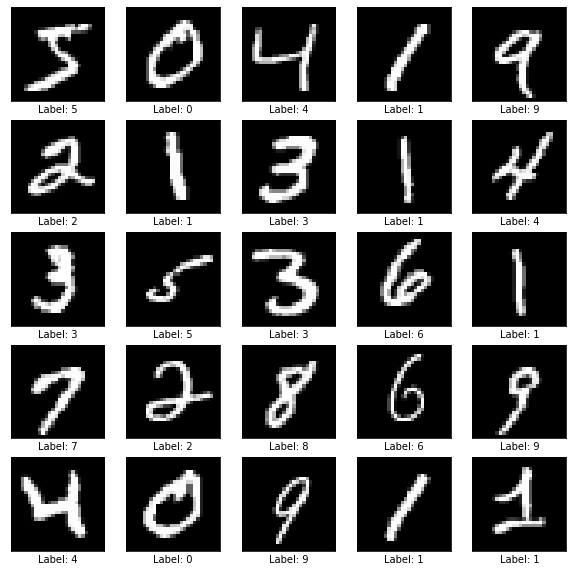

In [4]:
# Show the first 25 images in the training dataset.
show_sample(train_images, 
            ['Label: %s' % label for label in train_labels])

## Train a TensorFlow model to classify digit images
We use Keras API to build a TensorFlow model that can classify the digit images. Please see this [tutorial](https://www.tensorflow.org/beta/tutorials/keras/basic_classification) if you are interested to learn more about how to build machine learning model with Keras and TensorFlow.

In [ ]:
# Define the model architecture
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),

# Optional: You can replace the dense layer above with the convolution layers below to get higher accuracy.
    # keras.layers.Reshape(target_shape=(28, 28, 1)),
    # keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
    # keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    # keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # keras.layers.Dropout(0.25),
    # keras.layers.Flatten(input_shape=(28, 28)),
    # keras.layers.Dense(128, activation=tf.nn.relu),
    # keras.layers.Dropout(0.5),

    keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Train the digit classification model
model.fit(train_images, train_labels, epochs=5)

## Evaluate our model
We run our digit classification model against our test dataset that the model hasn't seen during its training process. We want to confirm that the model didn't just remember the digits it saw but also generalize well to new images.

In [ ]:
# Evaluate the model using test dataset.
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

In [ ]:
# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

# Then plot the first 25 test images and their predicted labels.
show_sample(test_images, 
            ['Predicted: %d' % np.argmax(result) for result in predictions])

## Convert the Keras model to TensorFlow Lite

In [ ]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model as file
f = open('mnist.tflite', "wb")
f.write(tflite_model)
f.close()

In [ ]:
# Download the digit classification model if you're using Colab, 
# or print the model's local path if you're not using Colab.
try:
  from google.colab import files
  files.download('mnist.tflite')
except ImportError:
  import os
  print('TF Lite model:', os.path.join(os.getcwd(), 'mnist.tflite'))

## Verify the TensorFlow Lite model

In [ ]:
# Download a test image
zero_img_path = keras.utils.get_file(
    'zero.png', 
    'https://storage.googleapis.com/khanhlvg-public.appspot.com/digit-classifier/zero.png'
)
image = keras.preprocessing.image.load_img(
    zero_img_path,
    color_mode = 'grayscale',
    target_size=(28, 28),
    interpolation='bilinear'
)

# Pre-process the image: Adding batch dimension and normalize the pixel value to [0..1]
# In training, we feed images in a batch to the model to improve training speed, making the model input shape to be (BATCH_SIZE, 28, 28).
# For inference, we still need to match the input shape with training, so we expand the input dimensions to (1, 28, 28) using np.expand_dims
input_image = np.expand_dims(np.array(image, dtype=np.float32) / 255.0, 0)

# Show the pre-processed input image
show_sample(input_image, ['Input Image'], 1)

In [ ]:
# Run inference with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
interpreter.set_tensor(interpreter.get_input_details()[0]["index"], input_image)
interpreter.invoke()
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])()[0]

# Print the model's classification result
digit = np.argmax(output)
print('Predicted Digit: %d\nConfidence: %f' % (digit, output[digit]))